In [33]:
%matplotlib inline

In [1]:
import xlrd
import os 
import sqlite3
import csv
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

In [2]:
db_path = '../datasets/datawarehouse.db'

## Target Variable: Price of AirBnB Listing

We have data on the 'price' for each listing from Q2 2022 - Q1 2023. As discovered in our EDA, the following is the query used to pull the information:

In [3]:
con=sqlite3.connect(db_path)
cur = con.cursor()

query = '''SELECT id, CAST(REPLACE(price, '$', '') AS FLOAT) as avg_price
FROM listings;
'''

cur.execute(query)
con.commit()

price_arr = cur.fetchall()

con.close()

We are pulling the listing id and its respective price as a tuple in a list. Since we are only interested in the price, we look at the second variable of each tuple and pull that into a list of its own. We then transfer this information into a dataframe:

In [4]:
cost_arr = []
for pairs in price_arr:
    cost_arr.append(pairs[1])
price = pd.DataFrame(cost_arr, columns = ["price"])

Let see the descriptive statistics: 

In [5]:
price.describe()

,price
count,8628.000000
mean,166.803083
std,130.819744
min,0.000000
25%,84.000000
50%,130.000000
75%,202.000000
max,999.000000


As we can see, there are 8626 listing between Q2 2022- Q1 2023 in Washington D.C. The average price of these AirBnBs is 166 US dollars with a standard deviation of 130 US dollars. The mininum price for a place is 0 dollars and the max is 999 dollars. We can definitely see a skew right since the median (130) < mean (166). 

Plotting the price distribution for Q2 2022 - Q1 2023, we have:

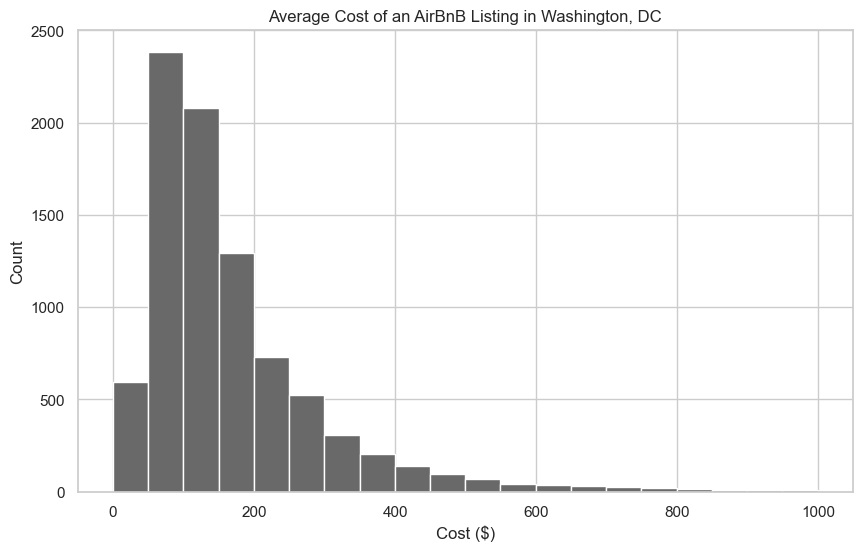

In [6]:
figure = plt.figure(figsize=(10, 6)) # first element is width, second is height.

axes = figure.add_subplot(1, 1, 1)

axes.hist(cost_arr, color="dimgray", bins=20)
axes.set_ylabel( "Count")
axes.set_xlabel( "Cost ($)")
axes.set_title( "Average Cost of an AirBnB Listing in Washington, DC")

plt.show()
plt.close()

As noted in our EDA, the distribution of this variable is skewed right and not normally distributed. It is important to understand the context of why the data is being generated like this. The data does not contains a "bell shaped curve" that is partly tied to the central limit theorem. That is, the average of the observations of this variable with finite moment and 2nd moment do not converges to the normal distribution as the number of sample increases. The data is postively skewed. That is the median of the observations is lower than the mean. There are more observations on the lower 50% percentile of the dataset than the upper 50% percentile. In this situaiton, there is no symmetry in the bell curve which violates the normality assumptions and takes us to transform the distribution we want to fit for our model. Since the data reflects the time of a pricing for a particular listing. This might be considered as the spatial time between events and it makes sense. 

### Data Generating Story 

The price listing of Airbnbs varies significantly based on the demand for that specific unit. With this said, it can be noted that the demand for Airbnbs is high for Airbnbs that are cheaper and there is gradually less demand for Airbnbs that are more expensive. However, it is important to note that there is a point in the Airbnbs where the demand is as low as expensive Airbnb. That is, Airbnbs that are too cheap, people do not want to rent this Airbnb. Thus, as mentioned, because these prices are within a timeframe and are independent from each other, this distribution is most likely an exponential distribution or a family of the exponential distribution. 

## Null Model / Baseline Model 

In order to create a mean model (null model), since the data is not normally distributed, we can use Chebyshev's inequality and note that at least %75 of the data must be within 2 standard deviations from the mean (k =2). In order to do this, the following are the steps taken to create a model: 

In [7]:
#Describes the location and scale of the data observed
y_bar = np.mean(price)
std = np.std(price)

#ybar as yhat predicts the future values we will observe

y_hat = np. mean(price) 
y_std = np.std(price)


# Predictive model: Assuming a non- normally distributed variable and  giving our estimates some error bounds (75% probability interval): 
print(y_hat, "(", y_hat-2*y_std, ",", y_hat+2*y_std, ")")


price    166.803083
dtype: float64 ( price   -94.821243
dtype: float64 , price    428.427409
dtype: float64 )


It is important to note that values cannot be negative, therefore the bounds would be 0 to 428.43. This is too big of a range and not an appropiate model. 

## Distributional Model 

As noted, because we suggested that this variable most likely represents an exponential distribution or a family of the exponential distribution, we'll start with the Gamma distribution as a model since the Gamma Distribution is commonly used to portary econometric data. 
[Gamma](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html).
The Gamma parameters uses a scale and location parameter to be in the distribution. 
Prior to incorporating the Gamma distribution, let's start with the Method of Moments estimators.

For reference, the empirical mean and standard deviation are:

In [9]:
price_mean = price.mean()
price_std = price.std()
print(price_mean)
print(price_std)

price    166.803083
dtype: float64
price    130.819744
dtype: float64


However, we need the *variance* for the second moment:

In [10]:
price_var = price.var()
price_var

price    17113.805545
dtype: float64

The Method of Moments parameters estimates are:

In [11]:
k = (price_mean**2)/price_var
k

price    1.625779
dtype: float64

In [12]:
theta = price_var/price_mean
theta

price    102.598856
dtype: float64

In [13]:
np.sqrt(k* theta**2)

price    130.819744
dtype: float64

Notice that these are not the same as the `mean` and `std` of the *empirical* distribution.

Fitting the gamma distribution:

In [14]:
from scipy.stats import gamma

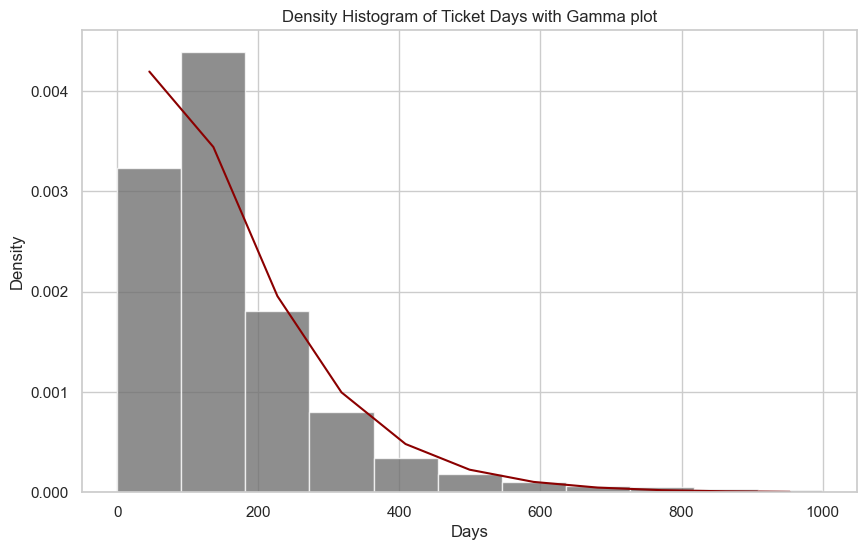

In [15]:
figure = plt.figure(figsize=(10,6))

axes = figure.add_subplot(1, 1, 1)
n, bins, patches = axes.hist(price, color="DimGray", density=True, bins=11, alpha=0.75)
axes.set_xlabel( "Days")
axes.set_ylabel( "Density")
axes.set_title("Density Histogram of Ticket Days with Gamma plot")

xs = [(b2 + b1)/2 for b1, b2 in zip(bins, bins[1:])]    

ys = [gamma.pdf( x, k, loc=0, scale=theta) for x in xs]
axes.plot(xs, ys, color="darkred")

plt.show()
plt.close()

Now, how is this model performing?

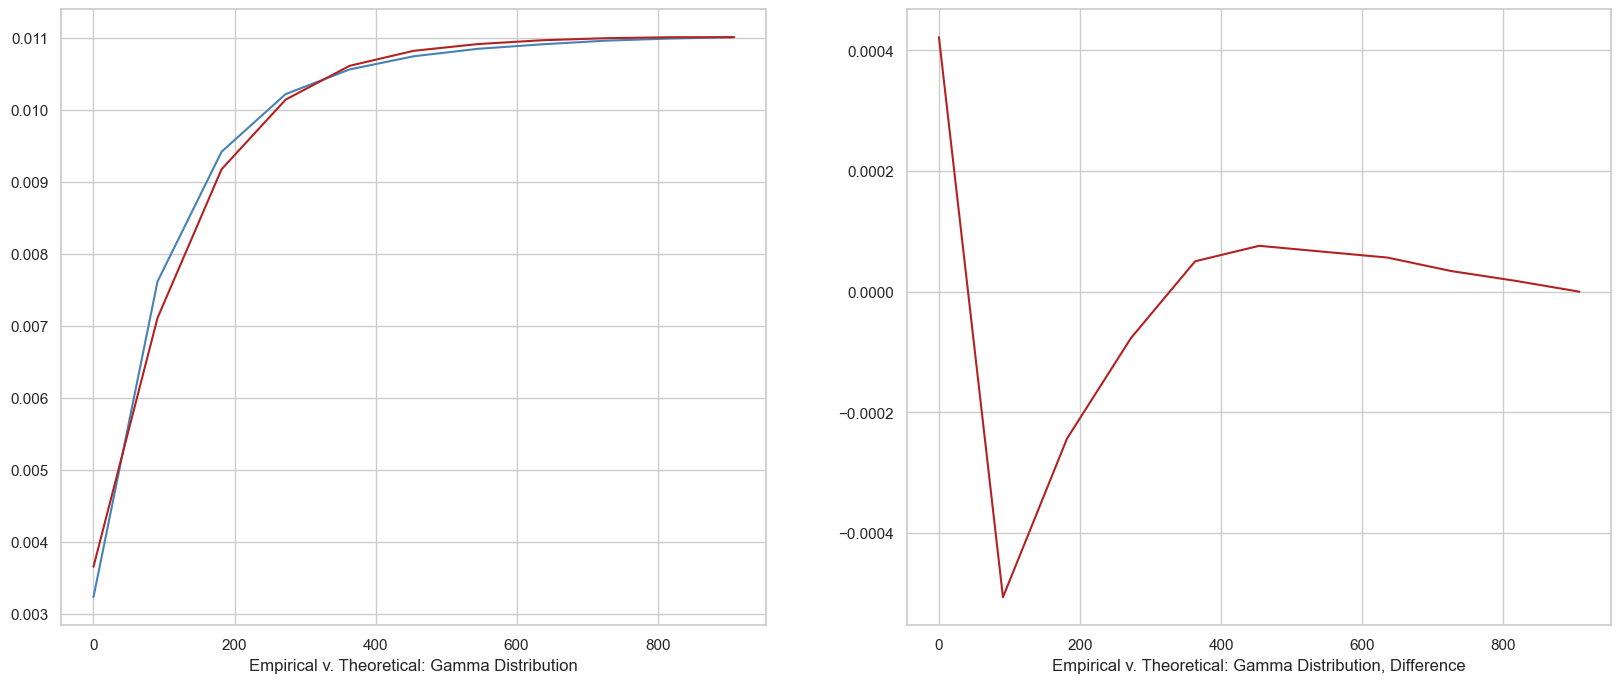

In [16]:
figure = plt.figure(figsize=(20, 8))

ticket_mn = np.min(price)
ticket_mx = np.max(price)
mean = np.mean(price)
std = np.std(price)

axes = figure.add_subplot(1, 2, 1)

values, base = np.histogram(price, bins=11, density=True)
cumulative = np.cumsum(values)
axes.plot(base[:-1], cumulative, color="steelblue")
#axes.set_xlim((ticket_mn, ticket_mx))

values2, base = np.histogram(gamma.rvs(k, loc=0, scale=theta, size=10000), bins=base, density=True)
cumulative2 = np.cumsum(values2)
axes.plot( base[:-1], cumulative2, color="firebrick")
#axes.set_xlim((ticket_mn, ticket_mx))
axes.set_xlabel( "Empirical v. Theoretical: Gamma Distribution")

axes = figure.add_subplot(1, 2, 2)

differences = cumulative2 - cumulative
axes.plot(base[:-1], differences, color='firebrick')
#axes.set_xlim((ticket_mn, ticket_mx))
#axes.hlines(0, 0, 14000, linestyles="dotted")
axes.set_xlabel( "Empirical v. Theoretical: Gamma Distribution, Difference")

plt.show()
plt.close()

The model looks pretty good. Notices how the empirical overlays with the theoritical distribution. If we were to see the error bounds as we did with the null model, what would this be? 

In [17]:
gamma.ppf([0.025, 0.975], k, loc=0, scale=theta)

array([ 14.09202633, 503.3850261 ])

The error bounds would be between 14 dollars to 503 dollars. 